In [ ]:
# prerequisites

import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt

from tensorflow.keras.layers import *
from tensorflow.keras import Model

from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse
from tensorflow.keras.utils import to_categorical

import os

In [ ]:
# data load

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))

In [ ]:
# one-hot encoding

y_train_cat = to_categorical(y_train).astype(np.float32)
y_test_cat  = to_categorical(y_test).astype(np.float32)
num_classes = y_test_cat.shape[1]

In [ ]:
# latent space dimensionality

n_latent=8

In [ ]:
# encoder

input_img = Input(shape=(28, 28, 1))
input_lbl = Input(shape=(num_classes,), dtype='float32')

x = Flatten()(input_img)
x_encoded = Dense(64, activation='relu')(x)
mu = Dense(2, activation = 'linear', name = 'MU')(x_encoded)
log_var = Dense(2, activation='linear', name = 'Log_var')(x_encoded)

In [ ]:
# sampling/reparametrization function 

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(n_latent,), name = 'Z')([mu, log_var])
z_cond = Concatenate(axis=-1, name='Concat')([z, input_lbl])

In [ ]:
# decoder

z_in = Input(shape=(2,), name ='z-in')
lbl_in = Input(shape=(num_classes,), name = 'Condition')
dec_input = Concatenate(name = 'Decoder_input')([z_in,lbl_in])
dec = Dense(784, activation='sigmoid')(dec_input)
outp = Reshape((28,28,1))(dec)

In [ ]:
# individual variables for encoder and decoder

E = Model([input_img, input_lbl], [mu, log_var, z, input_lbl])
D = Model([z_in, lbl_in], outp)

out = D(E([input_img, input_lbl])[2:])

In [ ]:
# loss

reconstruction_loss = keras.losses.binary_crossentropy(keras.layers.Flatten()(input_img), 
                                                       keras.layers.Flatten()(out))
kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
cvae_loss = reconstruction_loss + kl_loss

In [ ]:
# build model

cvae = Model([input_img, input_lbl], out)
cvae.add_loss(cvae_loss)
cvae.compile(optimizer='adam')

In [ ]:
# train

cvae.fit([x_train, y_train_cat],
       shuffle=True,
       epochs=10,
       batch_size=50,
       validation_data=([x_test, y_test_cat], None), verbose=1)

Epoch 1/10
1200/1200 [==============================] - 6s 4ms/step - loss: 0.4508 - val_loss: 0.3192
Epoch 2/10
1200/1200 [==============================] - 6s 5ms/step - loss: 0.2797 - val_loss: 0.2533
Epoch 3/10
1200/1200 [==============================] - 6s 5ms/step - loss: 0.2433 - val_loss: 0.2339
Epoch 4/10
1200/1200 [==============================] - 5s 4ms/step - loss: 0.2311 - val_loss: 0.2262
Epoch 5/10
1200/1200 [==============================] - 5s 4ms/step - loss: 0.2259 - val_loss: 0.2227
Epoch 6/10
1200/1200 [==============================] - 5s 4ms/step - loss: 0.2234 - val_loss: 0.2210
Epoch 7/10
1200/1200 [==============================] - 5s 4ms/step - loss: 0.2221 - val_loss: 0.2200
Epoch 8/10
1200/1200 [==============================] - 5s 4ms/step - loss: 0.2214 - val_loss: 0.2195
Epoch 9/10
1200/1200 [==============================] - 5s 4ms/step - loss: 0.2211 - val_loss: 0.2193
Epoch 10/10
1200/1200 [==============================] - 5s 4ms/step - loss: 0.220

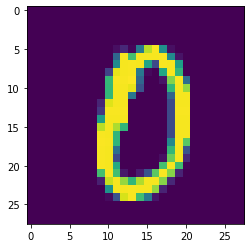

In [ ]:
# example of digit

plt.imshow(x_test[55].reshape((28,28)))

In [ ]:
# digit's label

y_test_cat[55]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

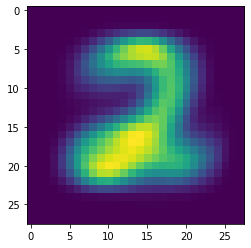

In [ ]:
# generate digit 0 in the style of digit 2

generated = cvae.predict([x_test[55].reshape((-1, 28, 28, 1)), y_test_cat[77].reshape((-1, 10))])
plt.imshow(generated.reshape((28,28)))